<a href="https://colab.research.google.com/github/andreusjh99/Learning-Tensorflow2.0/blob/master/Functional_API_(Basics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Functional API**
Author: [Chia Jing Heng](https://github.com/andreusjh99)

This notebook explores the basics of using `Keras Functional API` to create and a model architecture. The bulk of this tutorial is from the [tensorflow official guide](https://www.tensorflow.org/guide/keras/functional).

# When to use the Functional API?

The Keras functional API is a way to create models that is more flexible than the `tf.keras.Sequential` API. The functional API can handle models with:
* non-linear topology (eg residual connections)
* shared layers (eg shared embedding layers)
* multiple inputs or outputs.
* ensemble models

The main idea is that a deep learning model is usually a *directed acyclic graph* (DAG) of layers. So the functional API is a way to build *graphs of layers*.


#### Setup

In [1]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


# Creating a model

## Basic model architectures

Structure of model representation:
1. input
2. layers
3. output

You start by creating an input node (object), specifying also the shape of the input.

You then specify the layers.

### Inputs and layers

In [3]:
inputs = keras.Input(shape = (784,))
x = layers.Dense(64, activation = "relu", name = "input_layer")(inputs)
x = layers.Dense(64, activation = "relu", name = "hidden_dense1")(x)
outputs = layers.Dense(10, name = "output_layer")(x)

Note that each layer takes in an input argument at the end, which specify the input to that layer.

Another way to write the layers is that you could define the layers first then only specify the input and output of the layers, for eg for the hidden dense layer (line 3):

        dense = layers.Dense(64, activation = "relu", name = "hidden_dense1")
        x = dense(x)

This is, however, typically not used to save space unless for shared layers (see later).

### Instantiate and visualise 
After specifying the inputs, layers and outputs for the model, you now create a `Model` by specifying its inputs and outputs.

In [4]:
model1 = keras.Model(inputs=inputs, outputs=outputs, name="model1")

You could inspect the architecture, the number of weights/biases, the shape of output at each layer etc. with `model.summary()`. 

In [5]:
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
input_layer (Dense)          (None, 64)                50240     
_________________________________________________________________
hidden_dense1 (Dense)        (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You could also visualise the model as a graph. This is especially useful for very complicated models.

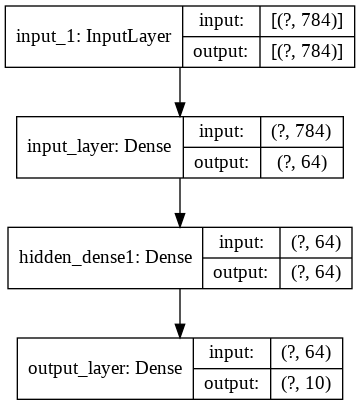

In [7]:
keras.utils.plot_model(model1, show_shapes = True)

## Accessing layers

Just like for Sequential models, you could access layers to extract features from the layers, for example the output of a hidden layer. You could essentially create an additional model that extracts the outputs of all intermediate layers in the model.

This works because once a model has been built, every layer has an `input` and `output` attribute.

In [8]:
model1.layers

In [9]:
model1.get_layer(name="hidden_dense1") # access layer by name

In [10]:
# Creating a feature extractor model
feature_extractor = keras.Model(
    inputs = model1.inputs,
    outputs = [layer.output for layer in model1.layers]
)

# Other uses/architectures
The brilliant bit of the Functional API is its ease of use for complex architectures relative to the Sequential API. Here we explore a few of these.

## Use same graph for multiple models

You might want to use the same stack of layers for two different models. Functional API makes it easy to achieve that.

In this example, the same stack of layers are used to instantiate 2 models: an encoder model and an autoencoder model.

In [11]:
# stack of layers to be used by multiple models
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

In [12]:
# encoder
encoder = keras.Model(encoder_input, encoder_output, name = "encoder")
encoder.summary()

# autoencoder
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

NOTE: they don't share the stack of layers, i.e. they don't share the weights, just the architecture.

## Concatenating models (Calling models like layers)

You can treat any model as if it were a layer. By calling a model you aren't just reusing the architecture of the model, but also the weights!

This example is also an autoencoder, but this autoencoder is constructed by two separate models: an encoder and a decoder.

In [13]:
# encoder
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

# decoder
decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
# decoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                18672     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


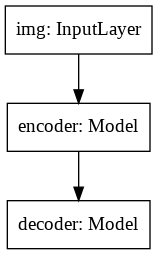

In [16]:
# Concatenating both to form autoencoder
autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

keras.utils.plot_model(autoencoder)

## Ensemble of models
The same model is instantiated thrice and they are called like layers on the inputs in the final ensemble model.

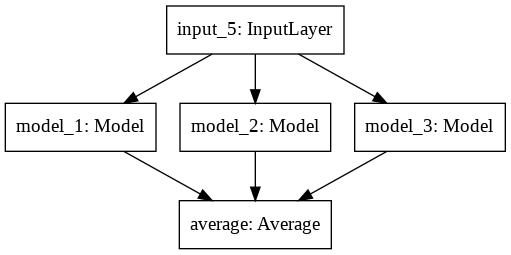

In [15]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(ensemble_model)

## Non-linear model topology
These are models with layers that are not connected sequentially. Eg: a ResNet model.

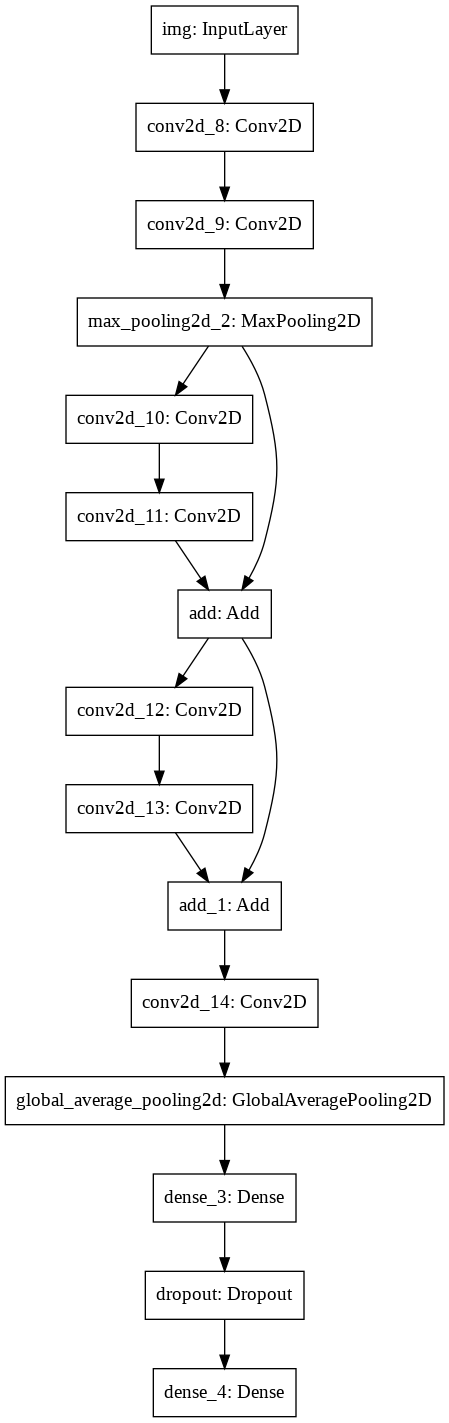

In [17]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output]) # residual connection

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output]) # residual connection

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")

keras.utils.plot_model(model)

## Multiple inputs and outputs
Functional API makes it easy to manipulate multiple inputs and outputs, which is something Sequential API can't handle.

In this example, we consider three inputs: `title_input`, `body_input`, `tags_input`, and two outputs: `priority_pred`, `department_pred`

In [18]:
# the three inputs
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

In [19]:
# LAYERS
# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# OUTPUTS
# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

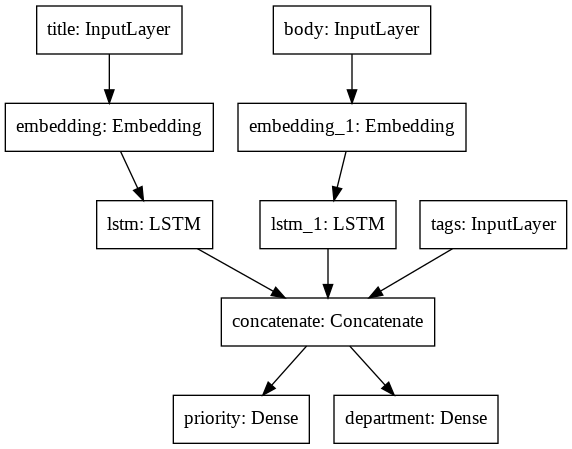

In [20]:
# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

keras.utils.plot_model(model)

When compiling the model, you can assign different losses to each output.

A good practice is to specify names for outputs (in fact, the inputs and layers too), especially when you have multiple outputs. This allows you to specify the different losses in `compile()` in a clearer way.

More on `compile()` in [this notebook](https://github.com/andreusjh99/Learning-Tensorflow2.0/blob/master/Training_And_Evaluation_(Keras_API).ipynb).

In [21]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

To fit,

        model.fit(
            {"title": title_data, "body": body_data, "tags": tags_data},
            {"priority": priority_targets, "department": dept_targets},
            epochs=num_epochs,
            batch_size=batch_size,
        )

where `title_data`, `body_data`, `tags_data`, `priority_targets`, `dept_targets` are `NumPy` arrays of the 3 inputs and 2 outputs.

Typically, for multiple inputs/outputs it will be easier to use `NumPy` arrays for the input and output data rather than `Dataset`'s.


## Shared layers
Shared layers are often used to encode inputs from similar spaces. They enable sharing of information across these different inputs.

In this example, we share an `Embedding` layer across two inputs.

In [22]:
# LAYER TO BE SHARED
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

In [23]:
# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

# ...

# What's next?
What do you do then with you model? You train, evaluate it, and use it to predict.

This will be covered in [another notebook](https://github.com/andreusjh99/Learning-Tensorflow2.0/blob/master/Training_And_Evaluation_(Keras_API).ipynb).

# Appendix